In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T
import os
import random
from PIL import  Image
import time
import numpy as np

In [14]:
class CatDataset(Dataset):
    def __init__(self, root, train = True, validate = False, test = False, transform=None):
        num = 0
        self.Ipath = "./train/"
        self.train = train
        self.validate = validate
        self.test = test
        if train:
            self.num = 3840
        else:
            self.num = 1280
        self.imgs = [os.path.join(root,img) for img in os.listdir(root)] 
        random.shuffle(self.imgs)
        if transform is None:

            normalize = T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
 
            if not train: 
                self.transform = T.Compose([
                    T.Scale(224),
                    T.CenterCrop(224),
                    T.ToTensor(),
                    normalize
                    ]) 
            else :
                self.transform = T.Compose([
                    T.Scale(256),
                    T.RandomSizedCrop(224),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    normalize
                    ]) 

        
    def __getitem__(self, idx):
        index = idx
        img_path = self.imgs[index]
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        data = Image.open(img_path)
        if self.transform is not None:
            data = self.transform(data)
        return data, label
        
        
    def __len__(self):
        return self.num
        

In [15]:
class MyCNN(nn.Module):
    
    def __init__(self, image_size, num_classes):
        super(MyCNN, self).__init__()
        # conv1: Conv2d -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # conv2: Conv2d -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected layer
        self.fc = nn.Linear(64 * (image_size // 8) * (image_size // 8), 120)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(120, 84)
        self.ReLU = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(84, num_classes)
        self.drop = nn.Dropout(p=0.5)
        

    def forward(self, x):
        """
        input: N * 3 * image_size * image_size
        output: N * num_classes
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # view(x.size(0), -1): change tensor size from (N ,H , W) to (N, H*W)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.ReLU(x)
        #x = self.drop(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        #x = self.drop(x)
        output = self.fc3(x)
        return output

In [16]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    correct = 0.0
    total = 0
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        # forward
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        
        #print(outputs, " ", targets)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        # every 100 iteration, print loss
        if (i + 1) % 12 == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    print('Accuracy on Training Set: {:.4f} %'.format(100 * correct / total))
    return total_loss / len(train_loader)

In [17]:
def evaluate(model, val_loader, device, val = 0):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, targets) in enumerate(val_loader):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            
        accuracy = correct / total
        if val == 0:
            print('Accuracy on Validation Set: {:.4f} %'.format(100 * accuracy))
        else:
            print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        return accuracy

In [18]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [21]:
def fit(model, num_epochs, optimizer,train_loader,validation_loader, test_loader, device = None, save_path = "./model/"):
    loss_func = nn.CrossEntropyLoss()

    model.to(device)
    loss_func.to(device)

    # log train loss and test accuracy
    losses = []
    accs = []
    bestLoss = 10000000
    besta = 0
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        """if loss < bestLoss:
            save_model(model, save_path)
            bestLoss = loss"""
        
        # evaluate step
        accuracy = evaluate(model, validation_loader, device)
        """if accuracy > 0.7 and accuracy > besta:
            besta = accuracy
            accuracy = evaluate(model, test_loader, device, 1)"""
        accs.append(accuracy)
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")
    accuracy = evaluate(model, test_loader, device, 1)

In [22]:
def save_model(model, save_path):
    # save model
    torch.save(model.state_dict(), save_path)

In [23]:
batch_size = 32
num_epochs = 20
lr = 0.003
image_size = 224
num_classes = 2
device = torch.device('cuda:3')

Epoch 1/20:
Step [12/120] Train Loss: 0.6910
Step [24/120] Train Loss: 0.6669
Step [36/120] Train Loss: 0.6663
Step [48/120] Train Loss: 0.6792
Step [60/120] Train Loss: 0.6950
Step [72/120] Train Loss: 0.7185
Step [84/120] Train Loss: 0.6828
Step [96/120] Train Loss: 0.7253
Step [108/120] Train Loss: 0.6756
Step [120/120] Train Loss: 0.6969
Accuracy on Training Set: 55.5208 %
Accuracy on Validation Set: 63.5156 %
Epoch 2/20:
Step [12/120] Train Loss: 0.7750
Step [24/120] Train Loss: 0.6708
Step [36/120] Train Loss: 0.6463
Step [48/120] Train Loss: 0.7119
Step [60/120] Train Loss: 0.7116
Step [72/120] Train Loss: 0.7074
Step [84/120] Train Loss: 0.7113
Step [96/120] Train Loss: 0.6336
Step [108/120] Train Loss: 0.6637
Step [120/120] Train Loss: 0.6694
Accuracy on Training Set: 58.3333 %
Accuracy on Validation Set: 64.6094 %
Epoch 3/20:
Step [12/120] Train Loss: 0.6382
Step [24/120] Train Loss: 0.6221
Step [36/120] Train Loss: 0.6570
Step [48/120] Train Loss: 0.6176
Step [60/120] Train 

Step [96/120] Train Loss: 0.4756
Step [108/120] Train Loss: 0.5247
Step [120/120] Train Loss: 0.5270
Accuracy on Training Set: 71.8490 %
Accuracy on Validation Set: 78.6719 %


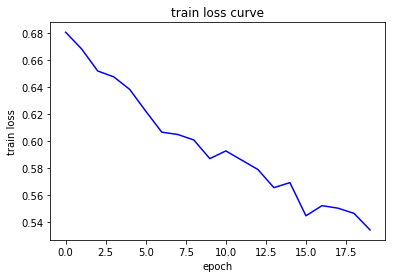

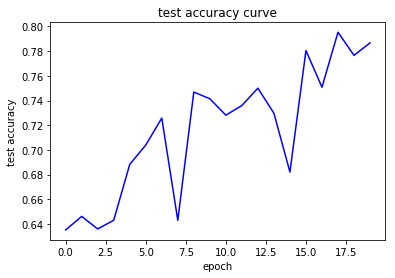

Accuracy on Test Set: 78.8281 %
time cost 1255.3747227191925 s


In [27]:
if __name__ == '__main__':
    

    trainset = CatDataset("./train/train/")
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    validationset = CatDataset('./train/validate/',  train = False, validate = True)
    validationloader = DataLoader(dataset=validationset, batch_size=batch_size, shuffle=False)
    testset = CatDataset('./train/test/',  train = False, test = True)
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)
    mycnn = MyCNN(image_size, num_classes)
    optimizer = torch.optim.SGD(mycnn.parameters(), lr=lr,  momentum=0.9)
    time_start=time.time()
    fit(mycnn, num_epochs, optimizer,trainloader, validationloader, testloader, device)
    time_end=time.time()
    print('time cost',time_end-time_start,'s')